In [1]:
# load packages
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_ztest

import sklearn as sk
from sklearn.metrics import auc
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [3]:
df = pd.read_csv('./Uplift_CLTV/uplift_synthetic_data_100trials.csv', nrows=10000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  10000 non-null  int64  
 1   trial_id                    10000 non-null  int64  
 2   treatment_group_key         10000 non-null  object 
 3   conversion                  10000 non-null  int64  
 4   control_conversion_prob     10000 non-null  float64
 5   treatment1_conversion_prob  10000 non-null  float64
 6   treatment1_true_effect      10000 non-null  float64
 7   x1_informative              10000 non-null  float64
 8   x2_informative              10000 non-null  float64
 9   x3_informative              10000 non-null  float64
 10  x4_informative              10000 non-null  float64
 11  x5_informative              10000 non-null  float64
 12  x6_informative              10000 non-null  float64
 13  x7_informative              1000

In [4]:
df.head()

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


In [5]:
df['treatment_group_key'].value_counts()

treatment_group_key
control       5000
treatment1    5000
Name: count, dtype: int64

In [6]:
df['treatment_group_key'] = df['treatment_group_key'].map(arg={'control':0, 'treatment1':1})

In [7]:
df['conversion'].mean()

0.3191

In [8]:
exp_results_df = \
df.groupby('treatment_group_key').agg({'conversion':['mean', 'sum', 'count']})
exp_results_df

conversion            
                          mean   sum count
treatment_group_key                       
0                       0.2670  1335  5000
1                       0.3712  1856  5000

In [9]:
(exp_results_df.loc[1,('conversion', 'mean')]
 - exp_results_df.loc[0,('conversion', 'mean')]).round(4)

0.1042

In [10]:
proportions_ztest(count=exp_results_df[('conversion', 'sum')],
                  nobs=exp_results_df[('conversion', 'count')])

(-11.177190529878043, 5.273302441543889e-29)

In [11]:
train, valid = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)
print(train.shape, valid.shape)

(8000, 43) (2000, 43)


In [12]:
features = ['treatment_group_key'] + df.columns.tolist()[7:]
print(features)

['treatment_group_key', 'x1_informative', 'x2_informative', 'x3_informative', 'x4_informative', 'x5_informative', 'x6_informative', 'x7_informative', 'x8_informative', 'x9_informative', 'x10_informative', 'x11_irrelevant', 'x12_irrelevant', 'x13_irrelevant', 'x14_irrelevant', 'x15_irrelevant', 'x16_irrelevant', 'x17_irrelevant', 'x18_irrelevant', 'x19_irrelevant', 'x20_irrelevant', 'x21_irrelevant', 'x22_irrelevant', 'x23_irrelevant', 'x24_irrelevant', 'x25_irrelevant', 'x26_irrelevant', 'x27_irrelevant', 'x28_irrelevant', 'x29_irrelevant', 'x30_irrelevant', 'x31_uplift_increase', 'x32_uplift_increase', 'x33_uplift_increase', 'x34_uplift_increase', 'x35_uplift_increase', 'x36_uplift_increase']


In [13]:
X_train = train[features]
y_train = train['conversion']
X_valid = valid[features]
y_valid = valid['conversion']

In [14]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

In [15]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [17]:
model.fit(X_train, y_train, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.68451	validation_1-auc:0.64675
[1]	validation_0-auc:0.71737	validation_1-auc:0.67071
[2]	validation_0-auc:0.72959	validation_1-auc:0.67839
[3]	validation_0-auc:0.73544	validation_1-auc:0.67805


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:48:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-auc:0.73926	validation_1-auc:0.68467
[5]	validation_0-auc:0.74544	validation_1-auc:0.68894
[6]	validation_0-auc:0.74564	validation_1-auc:0.68628
[7]	validation_0-auc:0.74991	validation_1-auc:0.69151
[8]	validation_0-auc:0.75218	validation_1-auc:0.69527
[9]	validation_0-auc:0.75437	validation_1-auc:0.70116
[10]	validation_0-auc:0.75690	validation_1-auc:0.70208
[11]	validation_0-auc:0.75785	validation_1-auc:0.70283
[12]	validation_0-auc:0.76098	validation_1-auc:0.70403
[13]	validation_0-auc:0.76391	validation_1-auc:0.70650
[14]	validation_0-auc:0.76874	validation_1-auc:0.70859
[15]	validation_0-auc:0.77023	validation_1-auc:0.70866
[16]	validation_0-auc:0.77223	validation_1-auc:0.71108
[17]	validation_0-auc:0.77353	validation_1-auc:0.71300
[18]	validation_0-auc:0.77531	validation_1-auc:0.71493
[19]	validation_0-auc:0.77967	validation_1-auc:0.71888
[20]	validation_0-auc:0.78085	validation_1-auc:0.71976
[21]	validation_0-auc:0.78272	validation_1-auc:0.72108
[22]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=2,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
X_valid_0 = X_valid.copy(); X_valid_0['treatment_group_key'] = 0
X_valid_1 = X_valid.copy(); X_valid_1['treatment_group_key'] = 1
Uplift = model.predict_proba(X_valid_1)[:,1]\
    - model.predict_proba(X_valid_0)[:,1]

Text(0, 0.5, 'Number of observations in validation set')

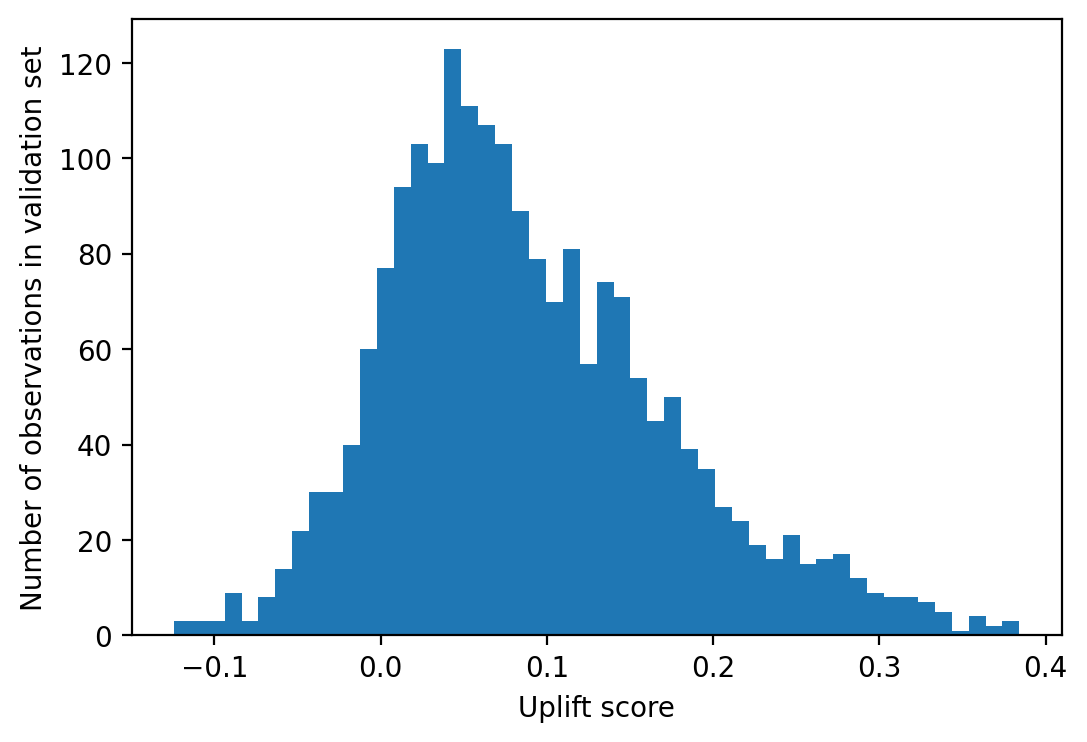

In [19]:
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (6,4)
plt.hist(Uplift, bins=50)
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')